## Task 0 - Exploratory Data Analysis and Data Preparation
Before building up our machine learning models, we would conduct exploratory data analysis and prepare the data at first.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint, t, sem

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestRegressor

In [2]:
#matplotlib set up
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('ggplot')

In [3]:
#set seed to ensure model reproducibility
SEED = 42

In [4]:
#load the data
bike = pd.read_csv('02_Bike rental.csv')

In [5]:
#first lines of the dataset
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Check if there are NA values:

In [7]:
bike.isna().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

There are no NA values in the dataset.

In [8]:
#the descriptive statistics of the columns with numerical values
bike.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


Let's validate the sum of the count of both casual and registered users that should equal the count of total rental bikes for every instance:

In [9]:
all(bike.casual + bike.registered == bike.cnt)

True

We can see that `casual` and `registered` contains exactly the same information as `cnt`. So, in order to make sure that the model will not be trained on inputs that already contains the information of the target value, we will thus only focus on `cnt` as our target value afterwards and drop `casual` and `registered` before we train the model as they are redundant.

Among the above viewed columns with numerical values, let's explore the distributions of columns `temp`, `atemp`, `hum` and `windspeed`. (It makes no sense to explore the distributions of other columns such as "holiday", "weekday" etc.)

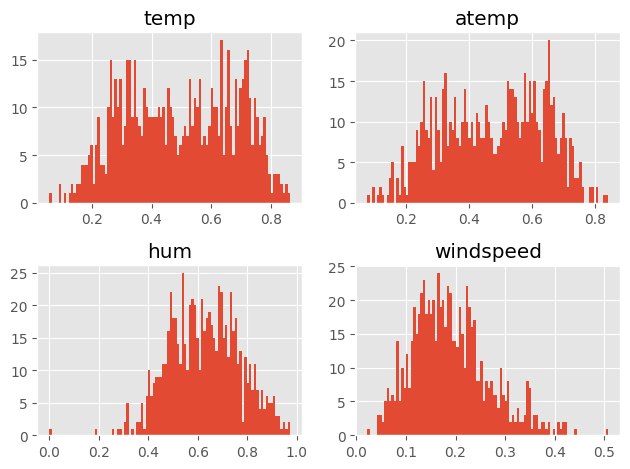

In [10]:
bike.hist(column=['temp', 'atemp', 'hum', 'windspeed'], bins=100)
plt.tight_layout()
plt.show()

### Transformation Pipeline
We can see that both `temp` and `atemp` columns are multimodal, to transform this kind of distribution, we will add a feature for the main mode of each distribution (0.7 in `temp` and 0.65 in `atemp` from the above histogram), representing the similarity between `temp` as well as `atemp` and their particular modes. We will use the Gaussian radial basis function (RBF) to compute the similarity by applying rbf_kernel() function; The `windspeed` column is right-skewed, on which we will perform log-transformation; The `hum` column will be standardized; The rest columns `instant`, `dteday`, `yr` will be dropped since they are not helpful to make predictions. `casual` and `registered` will also be dropped as we analysed above.

Note that `mnth` and `weekday` columns are cyclic data - data that has a unique set of values that repeat in a cycle. These features have a set of values and all the observations will have a value from this set only. There is a problem if we do not encode this kind of data: for example, the month 1 and 12 have the ordinal values with the biggest distance, however, they are next to each other on the timeline, so the ordinal values themselves are misleading for the model to make predictions. To encode these two columns with cyclical data, we transform the data into two dimensions using a sine and cosine transformation. We will map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- components of that point using sin and cos trigonometric functions. In this way, each ordinal time feature is transformed into 2 features that together encode equivalent information in a non-monotonic way, and more importantly without any jump between the first and the last value of the periodic range.

Based on this analysis, we will construct a transformation pipeline:

In [11]:
#create a preprocessing pipeline containing the transformation of all the categorical features with one-hot encoding;
#the cyclical columns with a defined function transformer, the rest numerical features with standard-scaler,
#and drop the rest of the columns that are not included in the pipeline.

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(2*np.pi*x / period), feature_names_out='one-to-one')

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(2*np.pi*x / period), feature_names_out='one-to-one')

def rbf_transformer(main_mode):
    return FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[main_mode]], gamma=0.1), feature_names_out='one-to-one')

log_pipeline = make_pipeline(FunctionTransformer(np.log, feature_names_out='one-to-one'), StandardScaler())

categorical_columns = ['season', 'holiday', 'workingday', 'weathersit']

#note that we also keep the original'temp' and 'atemp' here
#their new rbf-similarly features are added with "rbf_transformer" below
num_columns = ['temp', 'atemp', 'hum']

#note that columns not specified here are dropped
preprocessing = ColumnTransformer([
    ('sin_month', sin_transformer(12), ['mnth']),
    ('cos_month', cos_transformer(12), ['mnth']),
    ('sin_weekday', sin_transformer(7), ['weekday']),
    ('cos_weekday', cos_transformer(7), ['weekday']),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns),
    ('log', log_pipeline, ['windspeed']),
    ('rbf_temp', rbf_transformer(0.7), ['temp']),
    ('rbf_atemp', rbf_transformer(0.65), ['atemp']),
    ('num', StandardScaler(), num_columns),
])

## Task 1
Train and evaluate two different multiple regression models using different optimization algorithms.

In this task, we will split our dataset into training and test data and train two algorithms - Normal Equation and Stochastic Gradient Descent, where the normal equation can be used as our base model.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(bike.iloc[:, :-1], bike.cnt, test_size=0.3, random_state=SEED)

Get view of the transformed traing data.

In [13]:
pd.DataFrame(preprocessing.fit_transform(X_train), columns=preprocessing.get_feature_names_out()).head()

,sin_month__mnth,cos_month__mnth,sin_weekday__weekday,cos_weekday__weekday,cat__season_1,cat__season_2,cat__season_3,cat__season_4,cat__holiday_0,cat__holiday_1,...,cat__workingday_1,cat__weathersit_1,cat__weathersit_2,cat__weathersit_3,log__windspeed,rbf_temp__temp,rbf_atemp__atemp,num__temp,num__atemp,num__hum
0,-8.660254e-01,-0.500000,-0.974928,-0.222521,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,-0.747676,0.999993,0.999998,1.144306,1.076689,-1.553478
1,-5.000000e-01,0.866025,-0.433884,-0.900969,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,-0.293315,0.985788,0.989460,-0.992647,-0.967094,-0.094050
2,-5.000000e-01,0.866025,-0.974928,-0.222521,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,-0.036359,0.987477,0.990873,-0.863694,-0.826240,-0.774923
3,1.224647e-16,-1.000000,0.781831,0.623490,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.299978,0.999578,0.999766,0.739023,0.751792,-0.988064
4,5.000000e-01,0.866025,0.781831,0.623490,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.499664,0.981610,0.985106,-1.282794,-1.350777,-1.654131


Our processing pipeline functions well, we can now build and train the models.

We first develop a regression model that is optimized with normal equation, which can serve as our base model.

In [14]:
# Create linear regression model
lin_reg = make_pipeline(preprocessing, LinearRegression())
# Fit the linear regression model
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sin_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                  ['mnth']),
                                                 ('cos_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x17b549f30>),
                                                  ['mnth']),
                                                 ('sin_w...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.7]],
                                                                               'gamma': 0.1}),
                                                  ['temp']),
                                                 ('rbf_atemp',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.65]],
                                                                               'gamma': 0.1}),
                                                  ['atemp']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum'])])),
                ('linearregression', LinearRegression())])

Please note that optimizing regression with normal equation gets slow when we have a large number of features, we will optimize the linear regression by using Stochastic Gradient Descent as next, which is better suited for cases where there are a large number of features or too many training instances to fit in the computer memory.

We will build a SGD that runs for 1,000 epochs or until the loss drops by less than 10<sup>-5</sup> during 100 epochs. It starts with a learning rate of 0.01, using the default learning schedule. Here we can see that SGD requires more hyperparameters than the normal equation.

In [15]:
# Create SGD model
sgd_reg = make_pipeline(preprocessing,
                        SGDRegressor(max_iter=1000, tol=1e-5, n_iter_no_change=100, eta0=0.01, penalty=None,
                                    random_state=SEED))
#fit the model
sgd_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sin_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                  ['mnth']),
                                                 ('cos_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x17b549f30>),
                                                  ['mnth']),
                                                 ('sin_w...
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.7]],
                                                                               'gamma': 0.1}),
                                                  ['temp']),
                                                 ('rbf_atemp',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.65]],
                                                                               'gamma': 0.1}),
                                                  ['atemp']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum'])])),
                ('sgdregressor',
                 SGDRegressor(n_iter_no_change=100, penalty=None,
                              random_state=42, tol=1e-05))])

### Evaluate the models on both training data and validation data
We calculate `root mean squared error`, `mean absolute error` and `r2_score` of the trained model on the whole training data and also conduct 10-fold cross-validation to calculate the respective evaluation metrics by specifying the "scoring" parameter, and display the metrics together. We will create a function to output a dataframe of metrics:

In [16]:
def get_metrics(model, col_name):
    '''
    output a dataframe containing the performance metrics of a model
    by inputting the model and the desired column name of the output
    '''
    y_pred_train = model.predict(X_train)

    # Calculate performance metrics
    metrics = {
        'RMSE on training data:' : round(mean_squared_error(y_train, y_pred_train, squared=False), 4),
        'RMSE on validation data:' : round(-cross_val_score(model, X_train, y_train, 
                                            scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean(), 4),
        'MAE on training data:' : round(mean_absolute_error(y_train, y_pred_train), 4),
        'MAE on validation data:' : round(-cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',
                                                     cv=10, n_jobs=-1).mean(),4),
        'R2-score on training data:' : round(r2_score(y_train, y_pred_train), 4),
        'R2-score on validation data:' : round(-cross_val_score(model, X_train, y_train, scoring='r2',
                                                          cv=10, n_jobs=-1).mean(), 4),
    }

    return pd.DataFrame(pd.Series(metrics), columns=[col_name])

In [17]:
metrics_lin = get_metrics(lin_reg, 'linear regression')
metrics_sgd = get_metrics(sgd_reg, 'SGD')
pd.concat([metrics_lin, metrics_sgd], axis=1)

,linear regression,SGD
RMSE on training data:,1197.7649,1269.3511
RMSE on validation data:,1247.8026,1309.6174
MAE on training data:,1037.3198,1082.3584
MAE on validation data:,1079.0286,1119.1601
R2-score on training data:,0.6057,0.5572
R2-score on validation data:,-0.5432,-0.4963


We can see that the metrics on both training and validation data of the two models are not satisfying, meaning that the linear model with both normal equation and stochastic gradient descent optimization is underfitting, i.e., model is too simple to learn the underlying structure of the data. To further verify and visualize the effect, we will create a function to plot the learning curve of the models:

In [18]:
#make a copy of the dataset
df = bike.copy()
df = df.sample(n=len(df), random_state=SEED)

X, y = df.iloc[:, :-1], df.cnt

In [19]:
def plot_learning_curve(model):
    '''
    plot the learning curve of a given model
    '''
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, cv=5, n_jobs=-1,
                                        train_sizes=np.linspace(0.1, 1.0, 40), scoring="neg_root_mean_squared_error")
    train_errors = -train_scores.mean(axis=1)
    valid_errors = -valid_scores.mean(axis=1)

    plt.plot(train_sizes, train_errors, 'r-+', linewidth=2, label="training data")
    plt.plot(train_sizes, valid_errors, 'b-+', linewidth=2, label='validation data')
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc='upper right')

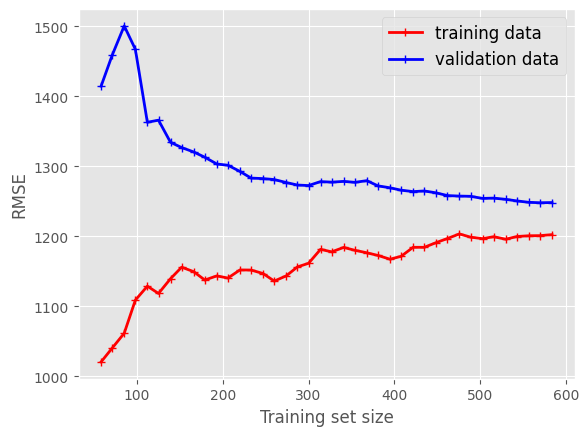

In [20]:
#display the learning curve of the linear regression model with normal equation
plot_learning_curve(lin_reg)
plt.show()

Consistent with the metrics above, this chart also shows that RMSE on both training and validation data is high. (Note that we won't plot the learning curve of the regression model with SGD, as the model could not converge with small training set size and generate warning messages that could not be suppressed after trials of many ways. Basically, the lines look similar.) 

To further verify our underfitting judgment, we train the models with "Ridge", "l2" and "ElasticNet" regularization and display the metrics accordingly. Please note that in practice, we will NEVER impose regularization on an underfitted model! Instead, we should reduce the constraints on the model to make it perform better. The only reason why we will do regularization below is just to make sure that regularization will make the metrics even worse in this situation, and thus further verify and underpin our judgment that the model is underfitting the data:

In [21]:
# Create Ridge model
ridge_reg = make_pipeline(preprocessing, Ridge(alpha=1.0, solver="sag")) #we use the default alpha here
#fit the model
ridge_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sin_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                  ['mnth']),
                                                 ('cos_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x17b549f30>),
                                                  ['mnth']),
                                                 ('sin_w...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.7]],
                                                                               'gamma': 0.1}),
                                                  ['temp']),
                                                 ('rbf_atemp',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.65]],
                                                                               'gamma': 0.1}),
                                                  ['atemp']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum'])])),
                ('ridge', Ridge(solver='sag'))])

In [22]:
metrics_ridge = get_metrics(ridge_reg, 'Ridge')
pd.concat([metrics_lin, metrics_ridge, metrics_sgd], axis=1)

,linear regression,Ridge,SGD
RMSE on training data:,1197.7649,1269.8450,1269.3511
RMSE on validation data:,1247.8026,1311.1952,1309.6174
MAE on training data:,1037.3198,1083.9424,1082.3584
MAE on validation data:,1079.0286,1119.8402,1119.1601
R2-score on training data:,0.6057,0.5569,0.5572
R2-score on validation data:,-0.5432,-0.4951,-0.4963


As expected, Ridge indeed makes the performance of our linear regression model even worse.

Let's then create a SGD model with l2 regularization. Please note that to ensure this model is on the same regularization level as our `ridge_reg` model with alpha=0.1 and thus the comparability is ensured, we specify `alpha=1.0/len(X_train)` for the following SGD model:

In [23]:
# Create SGD model with regularization
sgd_l2 = make_pipeline(preprocessing,
                        SGDRegressor(max_iter=10_000, tol=1e-5, n_iter_no_change=100, eta0=0.01, penalty='l2',
                                    alpha=1.0/len(X_train), random_state=SEED))
#fit the model
sgd_l2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sin_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                  ['mnth']),
                                                 ('cos_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x17b549f30>),
                                                  ['mnth']),
                                                 ('sin_w...
                                                                      kw_args={'Y': [[0.7]],
                                                                               'gamma': 0.1}),
                                                  ['temp']),
                                                 ('rbf_atemp',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.65]],
                                                                               'gamma': 0.1}),
                                                  ['atemp']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum'])])),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0019569471624266144, max_iter=10000,
                              n_iter_no_change=100, random_state=42,
                              tol=1e-05))])

In [24]:
metrics_sgd_l2 = get_metrics(sgd_l2, 'SGD with l2')
pd.concat([metrics_lin, metrics_ridge, metrics_sgd, metrics_sgd_l2], axis=1)

,linear regression,Ridge,SGD,SGD with l2
RMSE on training data:,1197.7649,1269.8450,1269.3511,1269.5332
RMSE on validation data:,1247.8026,1311.1952,1309.6174,1309.0909
MAE on training data:,1037.3198,1083.9424,1082.3584,1082.9389
MAE on validation data:,1079.0286,1119.8402,1119.1601,1119.2491
R2-score on training data:,0.6057,0.5569,0.5572,0.5571
R2-score on validation data:,-0.5432,-0.4951,-0.4963,-0.4968


The performance of our SGD model also doesn't get improved.

In [25]:
from sklearn.linear_model import ElasticNet

elastic_net = make_pipeline(preprocessing, ElasticNet(alpha=0.01, l1_ratio=0.3))
elastic_net.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sin_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                  ['mnth']),
                                                 ('cos_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x17b549f30>),
                                                  ['mnth']),
                                                 ('sin_w...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.7]],
                                                                               'gamma': 0.1}),
                                                  ['temp']),
                                                 ('rbf_atemp',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.65]],
                                                                               'gamma': 0.1}),
                                                  ['atemp']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum'])])),
                ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.3))])

In [26]:
metrics_net = get_metrics(elastic_net, 'metrics of Elastic Net')
pd.concat([metrics_lin, metrics_ridge, metrics_sgd, metrics_sgd_l2, metrics_net], axis=1)

,linear regression,Ridge,SGD,SGD with l2,metrics of Elastic Net
RMSE on training data:,1197.7649,1269.8450,1269.3511,1269.5332,1271.1886
RMSE on validation data:,1247.8026,1311.1952,1309.6174,1309.0909,1310.3967
MAE on training data:,1037.3198,1083.9424,1082.3584,1082.9389,1085.7065
MAE on validation data:,1079.0286,1119.8402,1119.1601,1119.2491,1120.0636
R2-score on training data:,0.6057,0.5569,0.5572,0.5571,0.5559
R2-score on validation data:,-0.5432,-0.4951,-0.4963,-0.4968,-0.4960


Not surprisingly, Elastic Net regression also impaired the model's performance in this situation. Now, we have sufficient arguments to conclude that regression models with both normal equation and SGD are too simple to learn the underlying structure of the data and are therefore underfitting. As next, we apply polynomial regression to increase the complexity of the model hoping to tackle the underfitting problem.

## Task 2
Train and evaluate a polynomial regression model.

In [27]:
#define a pipeline with polynomial features
def poly_pipeline(model, degree):
    '''
    pipeline with polynomial features;
    model and degree could be specified as input
    '''
    return make_pipeline(preprocessing, PolynomialFeatures(degree=degree, include_bias=False), model)

Let's firstly build a 2-degree polynomial regression model and see the performance.

In [28]:
poly2_lin = poly_pipeline(LinearRegression(), degree=2)
poly2_lin.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sin_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                  ['mnth']),
                                                 ('cos_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x17b549f30>),
                                                  ['mnth']),
                                                 ('sin_w...
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.7]],
                                                                               'gamma': 0.1}),
                                                  ['temp']),
                                                 ('rbf_atemp',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.65]],
                                                                               'gamma': 0.1}),
                                                  ['atemp']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum'])])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [29]:
#performance metrics
get_metrics(poly2_lin, 'poly2-lin')

,poly2-lin
RMSE on training data:,9.338291e+02
RMSE on validation data:,3.126435e+14
MAE on training data:,7.610440e+02
MAE on validation data:,6.090313e+13
R2-score on training data:,7.604000e-01
R2-score on validation data:,1.012858e+23


Obviously, the model is overfitting as it performs well on the training data, but poorly on the validation data, which means it does not generalize well. let's display it's learning curve to visualize the overfitting problem.

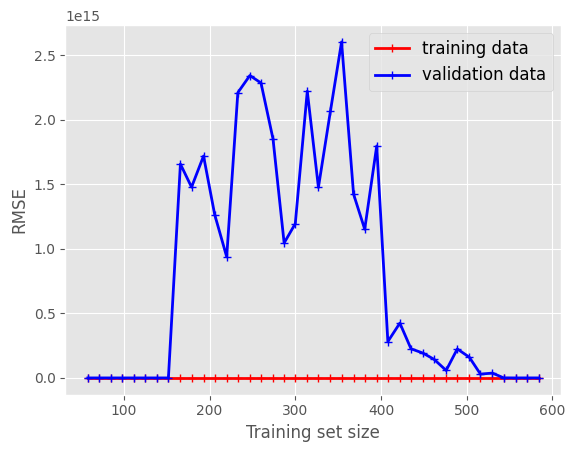

In [30]:
plot_learning_curve(poly2_lin)

The performance metrics are even not on the same scale, we thus adjust the `plot_learning_curve` function to log-scale the y-axis:

In [31]:
def plot_learning_curve_log(model):
    '''
    adjust the original plot_learning_curve function to log-scale the y-axis
    '''
    
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, cv=5, n_jobs=-1,
                                        train_sizes=np.linspace(0.1, 1.0, 40), scoring="neg_root_mean_squared_error")
    train_errors = -train_scores.mean(axis=1)
    valid_errors = -valid_scores.mean(axis=1)

    plt.plot(train_sizes, train_errors, 'r-+', linewidth=2, label="training data")
    plt.plot(train_sizes, valid_errors, 'b-+', linewidth=2, label='validation data')
    plt.yscale('log')
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc='upper right')

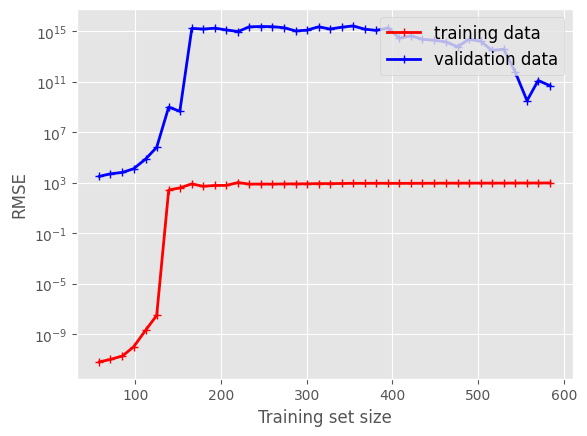

In [32]:
plot_learning_curve_log(poly2_lin)

We can now conclude that polynomial model with 2 degrees is severely overfitting the training data as the validation error is much higher than the training error! And of course, the polynomial model with degree = 3 also has the same problem:

In [33]:
poly3_lin = poly_pipeline(LinearRegression(), degree=3)
poly3_lin.fit(X_train, y_train)
get_metrics(poly3_lin, 'poly3-lin')

,poly3-lin
RMSE on training data:,0.0000
RMSE on validation data:,261431.2605
MAE on training data:,0.0000
MAE on validation data:,68997.6768
R2-score on training data:,1.0000
R2-score on validation data:,31992.2304


To handle overfitting, we regularize the 2-degree model by adding an ℓ₂ penalty (Ridge) to the cost function:

In [34]:
poly2_ridge = poly_pipeline(Ridge(alpha=1.0, solver="sag", max_iter=2000), degree=2) #we also use the default alpha=1.0 here
poly2_ridge.fit(X_train, y_train)

matrics_poly2_ridge = get_metrics(poly2_ridge, 'poly2-ridge')
matrics_poly2_ridge

,poly2-ridge
RMSE on training data:,1041.7430
RMSE on validation data:,1280.5952
MAE on training data:,891.2757
MAE on validation data:,1094.0246
R2-score on training data:,0.7018
R2-score on validation data:,-0.5235


In [35]:
#compare the performance of all the models
pd.concat([metrics_lin, metrics_ridge, metrics_sgd, metrics_sgd_l2, matrics_poly2_ridge], axis=1)

,linear regression,Ridge,SGD,SGD with l2,poly2-ridge
RMSE on training data:,1197.7649,1269.8450,1269.3511,1269.5332,1041.7430
RMSE on validation data:,1247.8026,1311.1952,1309.6174,1309.0909,1280.5952
MAE on training data:,1037.3198,1083.9424,1082.3584,1082.9389,891.2757
MAE on validation data:,1079.0286,1119.8402,1119.1601,1119.2491,1094.0246
R2-score on training data:,0.6057,0.5569,0.5572,0.5571,0.7018
R2-score on validation data:,-0.5432,-0.4951,-0.4963,-0.4968,-0.5235


We can see that the performance of ridge with degree-2 polynomial features is already better than any linear models before. Next, let's explore SGD with degree-2 polynomial features.

In [36]:
#SGD with degree-2 polynomial features (without regulaization)
poly2_sgd = make_pipeline(preprocessing,
                          PolynomialFeatures(degree=2, include_bias=False),
                          SGDRegressor(max_iter=10_000, tol=1e-5, n_iter_no_change=100,
                                       eta0=0.01, penalty=None, random_state=SEED))
poly2_sgd.fit(X_train, y_train)

matrics_poly2_sgd = get_metrics(poly2_sgd, 'poly2-sgd')
pd.concat([metrics_lin, metrics_ridge, metrics_sgd, metrics_sgd_l2, matrics_poly2_ridge, matrics_poly2_sgd], axis=1)

,linear regression,Ridge,SGD,SGD with l2,poly2-ridge,poly2-sgd
RMSE on training data:,1197.7649,1269.8450,1269.3511,1269.5332,1041.7430,1052.4021
RMSE on validation data:,1247.8026,1311.1952,1309.6174,1309.0909,1280.5952,1276.3083
MAE on training data:,1037.3198,1083.9424,1082.3584,1082.9389,891.2757,900.4859
MAE on validation data:,1079.0286,1119.8402,1119.1601,1119.2491,1094.0246,1092.6803
R2-score on training data:,0.6057,0.5569,0.5572,0.5571,0.7018,0.6956
R2-score on validation data:,-0.5432,-0.4951,-0.4963,-0.4968,-0.5235,-0.5277


SGD with degree-2 polynomial features delivers good results, although the model is also overfitting. We will finally train and evaluate the SGD model with degree-2 polynomial features and ℓ₂ penalty. Same as before, we specify `alpha=1.0/len(X_train)` to make it comparable with the `poly2_ridge` model.

In [37]:
#SGD with degree-2 polynomial features (with l2 regulaization)
poly2_sgd_l2 = make_pipeline(preprocessing, 
                             PolynomialFeatures(degree=2, include_bias=False),
                             SGDRegressor(max_iter=10_000, tol=1e-5, n_iter_no_change=100, eta0=0.01, 
                                          penalty='l2', alpha=1.0/len(X_train), random_state=SEED))
poly2_sgd_l2.fit(X_train, y_train)

matrics_poly2_sgd_l2 = get_metrics(poly2_sgd_l2, 'poly2_sgd with l2')
pd.concat([metrics_lin, metrics_ridge, metrics_sgd, metrics_sgd_l2, \
           matrics_poly2_ridge, matrics_poly2_sgd, matrics_poly2_sgd_l2], axis=1)

,linear regression,Ridge,SGD,SGD with l2,poly2-ridge,poly2-sgd,poly2_sgd with l2
RMSE on training data:,1197.7649,1269.8450,1269.3511,1269.5332,1041.7430,1052.4021,1055.7601
RMSE on validation data:,1247.8026,1311.1952,1309.6174,1309.0909,1280.5952,1276.3083,1268.4886
MAE on training data:,1037.3198,1083.9424,1082.3584,1082.9389,891.2757,900.4859,904.9254
MAE on validation data:,1079.0286,1119.8402,1119.1601,1119.2491,1094.0246,1092.6803,1089.6557
R2-score on training data:,0.6057,0.5569,0.5572,0.5571,0.7018,0.6956,0.6937
R2-score on validation data:,-0.5432,-0.4951,-0.4963,-0.4968,-0.5235,-0.5277,-0.5335


/Users/hongdao/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/hongdao/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/hongdao/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/hongdao/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve th

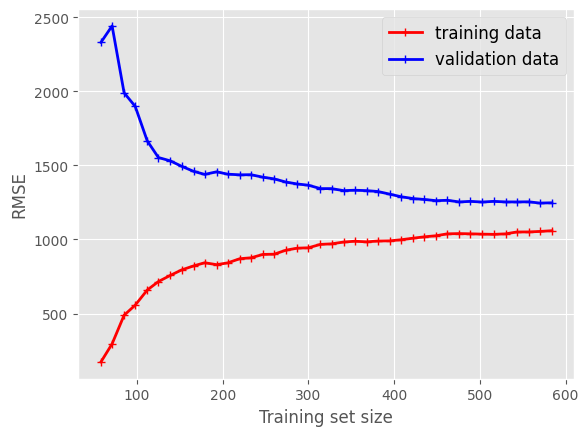

In [38]:
#display the learning curve of poly2_sgd_l2 model
plot_learning_curve(poly2_sgd_l2)

As the evaluation results suggest, polynomial regression models generally perform better than linear models in tast 1. Compared with the performance of the models in task 1, the polynomial regression models are able to learn the underlying structures of the data and thus solve the "underfitting" problem of linear models.

We can also see that the polynomial models are, on the contrary, overfitting the data with a better performance on the training set than on the validation set. 

As next, we will choose the SGD model with degree-2 polynomial features and ℓ₂ penalty and will optimize it in task 3 to reduce overfitting and to enhance the generalization ability of the model.

## Task 3
Optimization

As our selected `poly2_sgd_l2`, which delivers a better result on the training data than on the validation data, is still overfitting on the training data, we will try to reduce the overfitting problem by tuning the `alpha` (constant that multiplies the regularization term that is added to the cost function), `penalty` (regularization term) and `learning_rate` hyperparameter by performing randomized search.

In [39]:
param_distribs = {
    'sgdregressor__alpha': uniform(0.002, 0.2),
    'sgdregressor__penalty': ['l1', 'l2', 'elasticnet'],
    'sgdregressor__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

random_cv_poly2_sgd_l2 = RandomizedSearchCV(poly2_sgd_l2, param_distributions=param_distribs, 
                                            n_iter=50, cv=5, n_jobs=-1, random_state=SEED)

**NOTE**: the cell below generates a lot of warnings that although do not affect the training process, however, do take very much space and can not be suppressed after exhausting the suggestions on the internet. To avoid displaying the warnings, which make our notebook too long and exceed 30 pages, we simply hide the output of this cell by adjusting the settings of this notebook "Cell -> Current Outputs -> Clear", **after** we run this cell.

In [ ]:
#NOTE: this cell is already run, just its output is cleared afterwards
random_cv_poly2_sgd_l2.fit(X_train, y_train)

In [41]:
#display the above trained model
random_cv_poly2_sgd_l2

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('sin_month',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                                               ['mnth']),
                                                                              ('cos_month',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function cos_transformer.<locals>.<lambda...
                                              SGDRegressor(alpha=0.0019569471624266144,
                                                           max_iter=10000,
                                                           n_iter_no_change=100,
                                                           random_state=42,
                                                           tol=1e-05))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'sgdregressor__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16e73cac0>,
                                        'sgdregressor__learning_rate': ['constant',
                                                                        'optimal',
                                                                        'invscaling',
                                                                        'adaptive'],
                                        'sgdregressor__penalty': ['l1', 'l2',
                                                                  'elasticnet']},
                   random_state=42)

In [42]:
#the best hyperparameters
random_cv_poly2_sgd_l2.best_params_

{'sgdregressor__alpha': 0.1704569549189997,
 'sgdregressor__learning_rate': 'adaptive',
 'sgdregressor__penalty': 'l2'}

Now that we can get our finally optimized polynomial model with the best hyperparameters, we can access the best estimator using `best_estimator_` and evaluate it's performance as before:

In [43]:
tuned_poly2_sgd_l2 = random_cv_poly2_sgd_l2.best_estimator_

metrics_tuned_poly2_sgd_l2 = get_metrics(tuned_poly2_sgd_l2, 'optimized poly2_sgd with l2')
pd.concat([metrics_lin, metrics_ridge, metrics_sgd, metrics_sgd_l2, \
           matrics_poly2_ridge, matrics_poly2_sgd, matrics_poly2_sgd_l2, metrics_tuned_poly2_sgd_l2], axis=1)

,linear regression,Ridge,SGD,SGD with l2,poly2-ridge,poly2-sgd,poly2_sgd with l2,optimized poly2_sgd with l2
RMSE on training data:,1197.7649,1269.8450,1269.3511,1269.5332,1041.7430,1052.4021,1055.7601,1129.8162
RMSE on validation data:,1247.8026,1311.1952,1309.6174,1309.0909,1280.5952,1276.3083,1268.4886,1226.7334
MAE on training data:,1037.3198,1083.9424,1082.3584,1082.9389,891.2757,900.4859,904.9254,990.8978
MAE on validation data:,1079.0286,1119.8402,1119.1601,1119.2491,1094.0246,1092.6803,1089.6557,1078.5838
R2-score on training data:,0.6057,0.5569,0.5572,0.5571,0.7018,0.6956,0.6937,0.6492
R2-score on validation data:,-0.5432,-0.4951,-0.4963,-0.4968,-0.5235,-0.5277,-0.5335,-0.5627


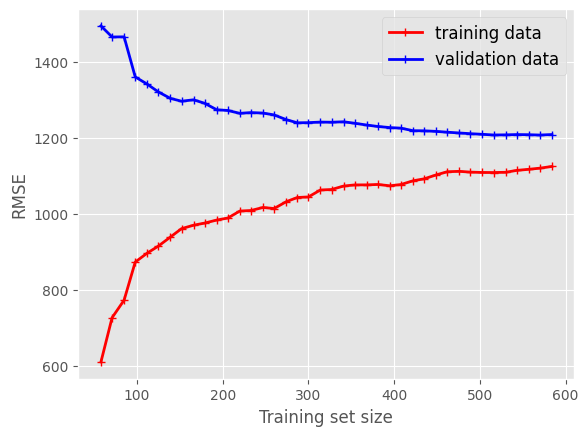

In [44]:
plot_learning_curve(tuned_poly2_sgd_l2)

As the result suggests, we further improved our model performance by reducing the RMSE on validation data to 1226.7334 and the model is less overfitting. However, to completely eliminate the overfitting problem, we will need more training data, because our data set is pretty small (only with 731 samples).

We will finally apply an ensemble learning technique in task 4 and see if more non-linear relationships could be caught.

## Task 4

Apply an ensemble learning technique.

We will train, evaluate and optimize a Random Forest Regressor to see if it performs better.

In [45]:
#build and train the model
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=SEED))
forest_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sin_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x17b549ea0>),
                                                  ['mnth']),
                                                 ('cos_month',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x17b549f30>),
                                                  ['mnth']),
                                                 ('sin_w...
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.7]],
                                                                               'gamma': 0.1}),
                                                  ['temp']),
                                                 ('rbf_atemp',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x129a8eb00>,
                                                                      kw_args={'Y': [[0.65]],
                                                                               'gamma': 0.1}),
                                                  ['atemp']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

Use cross-validation to get an estimate of a model’s generalization performance:

In [46]:
#get the performance metrics
metrics_rf = get_metrics(forest_reg, 'forest')
metrics_rf

,forest
RMSE on training data:,461.5854
RMSE on validation data:,1220.7884
MAE on training data:,383.3734
MAE on validation data:,1040.6839
R2-score on training data:,0.9414
R2-score on validation data:,-0.5675


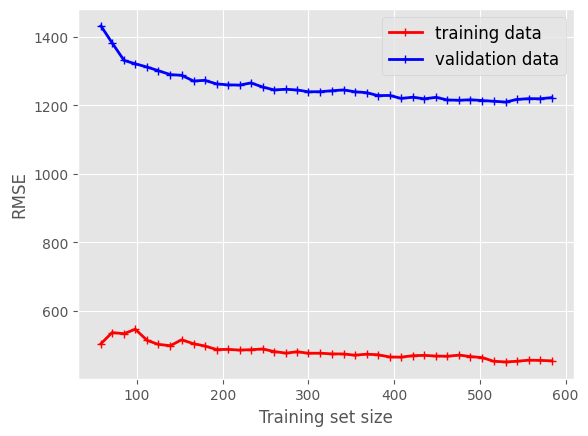

In [47]:
#plot the learning curve
plot_learning_curve(forest_reg)

We can see that the random forest regressor is obviously overfitting as it performs well on the training data but generalizes poorly according to the cross-validation metrics. Let's optimize it by tuning it's hyperparameters by using `RandomizedSearchCV`:

In [48]:
param_distribs = {
    'randomforestregressor__max_features': randint(2,21),
    'randomforestregressor__max_depth': randint(2, 7),
    'randomforestregressor__min_samples_leaf': randint(2, 15),
    'randomforestregressor__min_samples_split': randint(4, 30)

}

random_cv_rf = RandomizedSearchCV(forest_reg, param_distribs, n_iter=100, cv=5, n_jobs=-1, random_state=SEED)

#train the model
random_cv_rf.fit(X_train, y_train)

#the hyperparameters of the tuned model
random_cv_rf.best_params_

{'randomforestregressor__max_depth': 5,
 'randomforestregressor__max_features': 18,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__min_samples_split': 4}

In [49]:
#get the best model
tuned_rf = random_cv_rf.best_estimator_

#display the performance metrics of the new model along with the polynomial sgd selected previously
metrics_tuned_rf = get_metrics(tuned_rf, 'optimized forest')
pd.concat([metrics_tuned_poly2_sgd_l2, metrics_rf, metrics_tuned_rf], axis=1)

,optimized poly2_sgd with l2,forest,optimized forest
RMSE on training data:,1129.8162,461.5854,1015.0129
RMSE on validation data:,1226.7334,1220.7884,1232.8091
MAE on training data:,990.8978,383.3734,869.4330
MAE on validation data:,1078.5838,1040.6839,1064.5914
R2-score on training data:,0.6492,0.9414,0.7169
R2-score on validation data:,-0.5627,-0.5675,-0.5613


Hyperparameter tuning indeed reduced overfitting, however, compared to our optimized polynomial sgd model in task 3, the RMSE on validation data is not imporved. Moreover, although the MAE on validation data of the random forest regressor is better, since RMSE is more sensitive to outliers than the MAE, a poorer RMSE of the random forest regressor indicates that it is not as capable as the optimized polynomial sgd model to predict data near the boundary of the vector space, i.e., data with relatively large values.

### Evaluate on test set
Based on the analysis above, we will choose the optimized polynomial sgd model in task 3 as our final model. As last step, we evaluate the final model on the test data set (we also display the test result of the random forest model as comparison).

In [50]:
#final model
final_model = tuned_poly2_sgd_l2

#prediction of the final model on the test set
final_prediction = final_model.predict(X_test)

print("RMSE of optimized random forest on test set: ", mean_squared_error(y_test, tuned_rf.predict(X_test),
                                                                          squared=False))
print("RMSE of our final model on test set: ", mean_squared_error(y_test, final_prediction, squared=False))

RMSE of optimized random forest on test set:  1254.6122551820122
RMSE of our final model on test set:  1194.038516914066


On test set, our optimized polynomial sgd model also outperforms the tuned random forest regressor. We made the right decision to choose the optimized polynomial sgd model in task 3 as our final model.

## Final Though

At last, we also want to have an idea how precise this estimate on the test set is. In other words, we want to see if the generalization error will be reliable enough to convince us to launch the final model in production. For this, we compute 95% confidence interval for the generalization error:

In [51]:
confidence = 0.95

squared_errors = (y_test - final_prediction) ** 2
np.sqrt(t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=sem(squared_errors)))

array([1117.27102048, 1266.16011095])

The computed 95% confidence interval is satisfying, meaning that the testing result has a good representativeness. And our RMSE on test set (1194) is roughly in the middle of it.

To conclude, we finally select the regularized (with ℓ₂ penalty) Stochastic Gradient Descent model with degree-2 polynomial features as our machine learning model to deploy in production.